## Plot branchwater output
Used branchwater to look for microbes that are common in pig gut. 
Returns metagenomes. Count for each metagenome how many of these microbes are present. 
If more of these microbes (out of 16) are present, is the metagenome likely to be pig? (yes)

In [1]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2025-workflow-core99/'

# parquet files from branchwater
BASE_OUTPUTS=BASE+'/outputs.branchwater'

# set thresholds
#HASH_THRESHOLD=10
CONTAINMENT_THRESHOLD=0.05

# where to place figures
FIG_OUT=BASE+'/outputs.figures/'

In [2]:
# imports
import polars as pl
import numpy as np
import sklearn.tree
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [3]:
dirpath = BASE_OUTPUTS+'/manysearch.cds.*.parquet'

bw_df = pl.scan_parquet(dirpath).collect()
bw_df = bw_df.with_columns(pl.col("query_name").alias("species"),
                           pl.col("match_name").alias("acc"))
bw_df = bw_df.select(["species", "acc", "containment", "intersect_hashes"])

# set threshold
#bw_df = bw_df.filter(pl.col("intersect_hashes") >= HASH_THRESHOLD)
bw_df = bw_df.filter(pl.col("containment") >= CONTAINMENT_THRESHOLD)


In [4]:
# get metadata, only compare WGS
metadata_df = (
    pl.scan_parquet("/group/ctbrowngrp5/sra-metagenomes/20241128-metadata.parquet")
    .filter(pl.col("acc") != "NP")
    .filter(pl.col("assay_type") == "WGS")
    .select(["acc", "organism", "bioproject"]) 
    .collect()
)
print(len(metadata_df))

703916


In [5]:
bw_df = bw_df.join(metadata_df, on="acc", how="left")
bw_df['species'].unique()

species
str
"""s__Bariatricus sp004560705"""
"""s__Gemmiger qucibialis"""
"""s__Sodaliphilus sp004557565"""
"""s__Phascolarctobacterium_A suc…"
"""s__Cryptobacteroides sp9005469…"
…
"""s__UBA2868 sp004552595"""
"""s__Mogibacterium_A kristiansen…"
"""s__JALFVM01 sp022787145"""


In [6]:
# remove shitty entries with shitty metatada
def remove_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null"
    ]
    return df.filter(~pl.col("organism").is_in(bad_values))

# group by organism and count number of bacteria per SRA 
def pivot_count(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .group_by(["organism", "count"])
        .len()  # count occurrences
        .pivot(
            values="len",
            index="organism",
            columns="count"
        )
        .fill_null(0)  # optional: fill missing with 0
    )

# set mapping for "categories of interest" I like human v pig v neither. 
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords above
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  

# grouping data for plotting (either cumulative or infdividually)
def group_for_plot(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/other': '#2a9d8f',
    'pig-associated': '#e9c46a'
    }

# Plotting in numbers (xx metagenomes)
def plot_cat(df, *, ax=None):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        color=[colors[c] for c in df_abs.index],
        ax=ax,
    )
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', loc='upper right')
    #plt.tight_layout()


# plot relative percentages (x percent of the metagenomes (total 100%))
def plot_cat_percent(df, *, ax=None):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
    ax = df_norm.T.plot(
        kind='bar',
        stacked=True,
        figsize=(6,6),
        color=[colors[c] for c in df_norm.index],
        ax=ax,
    )
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    #plt.tight_layout()


In [7]:
# remove unnanotated metags (metagenome, gut metagenome, etc)
df = remove_unnannotated(bw_df)

# count number of orgs (out of 16) in each mG
counts_df = (
    df
    .group_by(["acc", "organism"])
    .len()
    .rename({"len": "count"})
)

# pivot for plotting
dfp = pivot_count(counts_df)

/tmp/ipykernel_2729998/3970032816.py:20: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


In [8]:
# save then load as pandas bc dont want to rewrite all functions
dfp.write_csv("tmp_orgcounts.csv")
dfp = pd.read_csv("tmp_orgcounts.csv")


In [9]:
# give entries categories (human, pig, other)
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
df_ind, df_cm = group_for_plot(dfp)

In [10]:
df_cm

,broad_cat,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,human associated,148830,128426,94862,82002,72568,56302,43566,21610,10394,5664,3378,1879,975,342,29
1,other,18626,9898,7874,6432,5598,4855,4092,3108,2585,2194,1866,1500,1196,926,608
2,pig,6863,6627,6504,6455,6401,6340,6273,6197,6092,5950,5778,5444,4986,4413,3394


In [11]:
5505 / 6855

0.8030634573304157

In [12]:
3761 / 163685

0.022977059596175582

In [13]:
5505 / (5505 + 3761)

0.5941074897474639

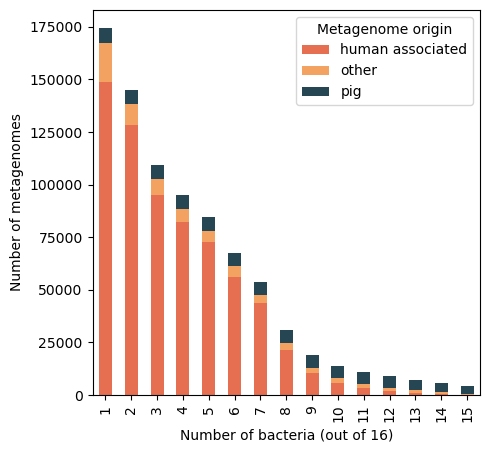

In [14]:
# make chart with absolute of metagenomes (cumulative)
plot_cat(df_cm)

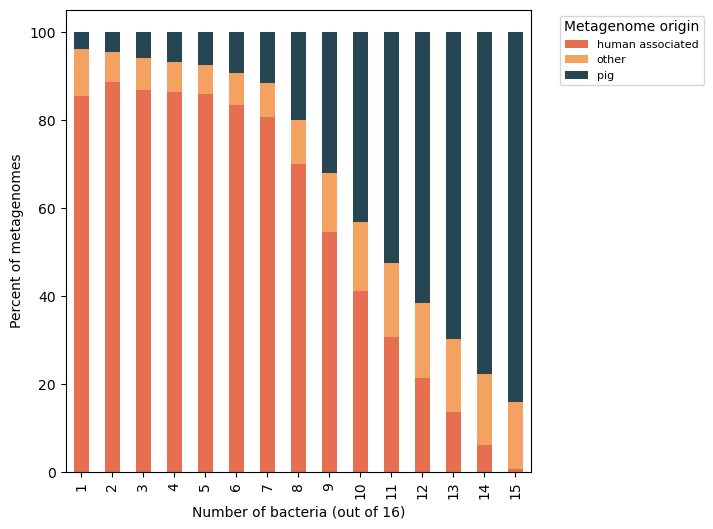

In [15]:
# plot percentage of metagenomes that has x microbial species (cumulative)
plot_cat_percent(df_cm)

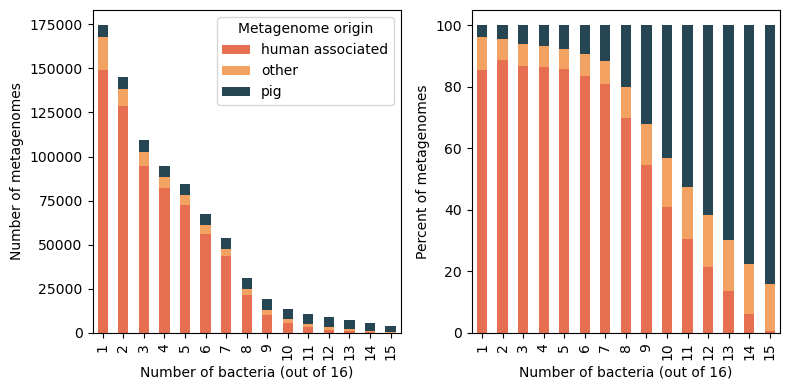

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) # Adjust figsize as needed

df = df_cm.copy()

numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
df_abs = df.set_index('broad_cat')[numeric_cols]
ax = df_abs.T.plot(
    kind='bar',
    stacked=True,
    #figsize=(5,5),
    color=[colors[c] for c in df_abs.index],
    ax=axes[0],
    label=None
)
axes[0].set_ylabel('Number of metagenomes')
axes[0].set_xlabel('Number of bacteria (out of 16)')
axes[0].legend(title='Metagenome origin', loc='upper right')
#axes[0].set_xlim(0.5, None)


numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
df_norm.T.plot(
    kind='bar',
    stacked=True,
    #figsize=(6,6),
    color=[colors[c] for c in df_norm.index],
    ax=axes[1],
)
axes[1].set_ylabel('Percent of metagenomes')
axes[1].set_xlabel('Number of bacteria (out of 16)')
axes[1].get_legend().remove()
#axes[0].legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(FIG_OUT + '/figure3-branchwater-barplot.png')

## Figure 3: Core bacteria largely select against human-associated metagenomes.

21-mer search of 700,000 public metagenomes with each of 16 bacterial species pangenomes  found almost 200,000 metagenomes containing at least one species at a containment threshold of 5%. Over 163,000 of these metagenomes were human-associated. Filtering metagenomes based on the number of contained species progressively eliminated the large majority of human metagenomes; when requiring 12 or more species, 80% of the pig metagenomes were retained while only 0.2% of the human metagenomes were retained.